In [2]:
from mftool import Mftool
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from yahooquery import Ticker
import datetime
from dateutil.relativedelta import relativedelta
from jugaad_data.nse import index_raw

%matplotlib inline

### Pulling Nifty Benchmark

In [3]:
n_years = 3 # Parameter for historical years

def convert_to_date(date_str):
    date_obj = datetime.datetime.strptime(date_str, '%d %b %Y')
    return date_obj

# Get from and to dates
from_date = datetime.datetime.strptime('1-1-2021', '%d-%m-%Y').date()
to_date = datetime.datetime.strptime('31-12-2023', '%d-%m-%Y').date()
print(from_date, to_date)

# Fetch the index data 
raw_index_data = index_raw(symbol="NIFTY MIDCAP 150", from_date=from_date, to_date=to_date)

# Converting into dataframe and processing the data
nifty_midcap_150 = (pd.DataFrame(raw_index_data)\
                            .assign(HistoricalDate=lambda x: x['HistoricalDate'].apply(convert_to_date),
                                    CLOSE=lambda x: x['CLOSE'].astype(float))\
                            .sort_values('HistoricalDate')\
                            .drop_duplicates()\
                            .loc[lambda x: x['Index Name'] == 'NIFTY MIDCAP 150']\
                            .reset_index(drop=True)\
                            .rename(columns={'HistoricalDate':'date'})
                   )
nifty_midcap_150

2021-01-01 2023-12-31


,Index Name,INDEX_NAME,date,OPEN,HIGH,LOW,CLOSE
0,NIFTY MIDCAP 150,NIFTY MIDCAP 150,2021-01-01,7877.85,7967.6,7876.3,7953.30
1,NIFTY MIDCAP 150,NIFTY MIDCAP 150,2021-01-04,8017.55,8075.75,7958.9,8068.05
2,NIFTY MIDCAP 150,NIFTY MIDCAP 150,2021-01-05,8038.75,8140.55,8002.6,8131.15
3,NIFTY MIDCAP 150,NIFTY MIDCAP 150,2021-01-06,8166.3,8215.2,8075.3,8160.60
4,NIFTY MIDCAP 150,NIFTY MIDCAP 150,2021-01-07,8237.1,8298.8,8226.15,8264.00
...,...,...,...,...,...,...,...
737,NIFTY MIDCAP 150,Nifty Midcap 150,2023-12-22,16661.35,16737.6,16575.5,16693.00
738,NIFTY MIDCAP 150,Nifty Midcap 150,2023-12-26,16761.8,16826.7,16712.05,16787.00
739,NIFTY MIDCAP 150,Nifty Midcap 150,2023-12-27,16873.5,16932.4,16775.9,16852.45
740,NIFTY MIDCAP 150,Nifty Midcap 150,2023-12-28,16909.4,16944.55,16848.4,16933.75


### mftool

In [4]:
mf = Mftool()
mutual_fund_code = '118989'
d1 = mf.get_scheme_quote(mutual_fund_code)
d2 = mf.get_scheme_details(mutual_fund_code)
{**d1, **d2}

{'scheme_code': 118989,
 'scheme_name': 'HDFC Mid-Cap Opportunities Fund - Growth Option - Direct Plan',
 'last_updated': '18-Jan-2024',
 'nav': '163.813',
 'fund_house': 'HDFC Mutual Fund',
 'scheme_type': 'Open Ended Schemes',
 'scheme_category': 'Equity Scheme - Mid Cap Fund',
 'scheme_start_date': {'date': '01-01-2013', 'nav': '18.79900'}}

#### Fetch NAV historicals and calculate cumulative returns

In [5]:
#Pull the mutual fund data
mutual_fund_code = '118989'
mutual_fund = 'HDFC Mid-Cap Opportunities Fund - Growth Option - Direct Plan'
start_date = pd.to_datetime('1-1-2021', format='%d-%m-%Y')
end_date = pd.to_datetime('31-12-2023', format='%d-%m-%Y')

df = mf.get_scheme_historical_nav(mutual_fund_code,as_Dataframe=True).reset_index()
df['nav'] = df['nav'].astype(float)
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')
df = df.sort_values('date')
df = df.query("date >= @start_date and date <=@end_date").reset_index(drop=True)

#Calculate cumulative returns 
df['daily_returns'] = df['nav'].pct_change()
df['cumulative_returns'] = (df['daily_returns']+1).cumprod()
df

,date,nav,dayChange,daily_returns,cumulative_returns
0,2021-01-01,70.467,0.782,NaN,NaN
1,2021-01-04,71.773,1.306,0.018533,1.018533
2,2021-01-05,72.291,0.518,0.007217,1.025884
3,2021-01-06,72.085,-0.206,-0.002850,1.022961
4,2021-01-07,72.311,0.226,0.003135,1.026168
...,...,...,...,...,...
733,2023-12-22,158.213,1.007,0.006406,2.245207
734,2023-12-26,159.199,0.986,0.006232,2.259199
735,2023-12-27,159.613,0.414,0.002601,2.265074
736,2023-12-28,160.646,1.033,0.006472,2.279734


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

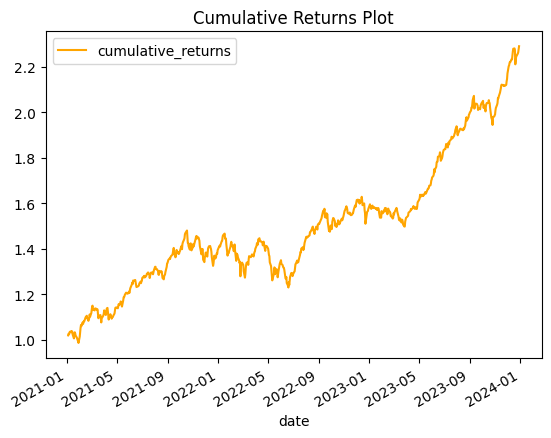

In [6]:
df.plot(x='date', y='cumulative_returns', color='orange')
plt.title('Cumulative Returns Plot')
plt.plot

#### Growth metrics

In [7]:
#Method 1
(df['cumulative_returns'].iloc[-1] - 1)*100

#Method 2
((df['nav'].iloc[-1]/df['nav'].iloc[0]) - 1)*100

129.15832943079738

In [8]:
n_years = 3
((df['nav'].iloc[-1]/df['nav'].iloc[0]) ** (1/n_years) - 1) * 100

31.839399383940826

### yahooquery

In [9]:
ticker = Ticker('0P0000XW8F.BO')
ticker.fund_top_holdings

symbol  \
symbol        row                  
0P0000XW8F.BO 0      INDHOTEL.BO   
              1    FEDERALBNK.NS   
              2    APOLLOTYRE.BO   
              3          MFSL.BO   
              4      TATACOMM.BO   
              5       COFORGE.BO   
              6     MAXHEALTH.BO   
              7       IPCALAB.BO   
              8       INDIANB.BO   
              9    PERSISTENT.NS   

                                                    holdingName  \
symbol        row                                                 
0P0000XW8F.BO 0                            Indian Hotels Co Ltd   
              1                            The Federal Bank Ltd   
              2                                Apollo Tyres Ltd   
              3                      Max Financial Services Ltd   
              4                         Tata Communications Ltd   
              5                                     Coforge Ltd   
              6    Max Healthcare Institute Ltd Ordinary Shares   
              7                           Ipca Laboratories Ltd   
              8                                     Indian Bank   
              9                          Persistent Systems Ltd   

                   holdingPercent  
symbol        row                  
0P0000XW8F.BO 0          0.036751  
              1          0.034414  
              2          0.033946  
              3          0.031424  
              4          0.031260  
              5          0.030777  
              6          0.029764  
              7          0.026792  
              8          0.025562  
              9          0.024133

,0P0000XW8F.BO
0,
realestate,0.0000
consumer_cyclical,0.1791
basic_materials,0.0973
consumer_defensive,0.0136
technology,0.1137
communication_services,0.0499
financial_services,0.2529
utilities,0.0000
industrials,0.1577


<Axes: ylabel='0'>

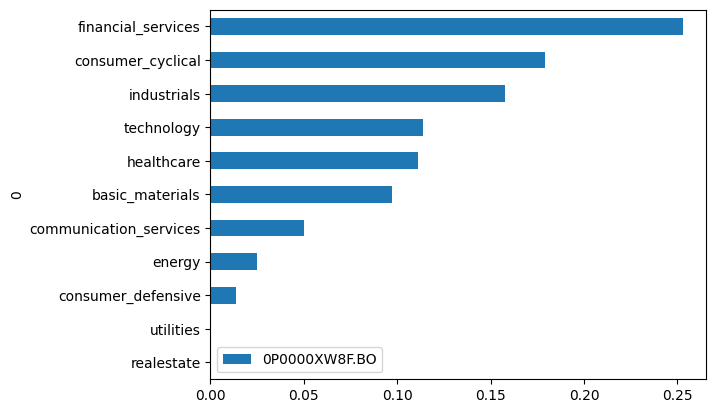

In [10]:
sector_weightings = ticker.fund_sector_weightings
display(sector_weightings)
sector_weightings.sort_values('0P0000XW8F.BO',).plot(kind='barh')

### Pulling multiple funds data & analyzing them

In [11]:
from mftool import Mftool
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def fetch_mutual_fund_data(mutual_fund_code):
    mf = Mftool()
    
    df = (mf.get_scheme_historical_nav(mutual_fund_code,as_Dataframe=True).reset_index()\
          .assign(nav=lambda x: x['nav'].astype(float), 
                 date=lambda x: pd.to_datetime(x['date'], format='%d-%m-%Y'))\
          .sort_values('date')\
          .reset_index(drop=True)\
         )
    
    return df

# Fetch data for these funds
mutual_funds = {
    '125307': 'PGIM India Midcap Opportunities Fund - Direct Plan - Growth Option', 
    '118989': 'HDFC Mid-Cap Opportunities Fund - Growth Option - Direct Plan', 
    '127039': 'Motilal Oswal Midcap Fund-Regular Plan-Growth Option', 
    '120726': 'UTI Mid Cap Fund-Growth Option- Direct'
    
}

mf_data_dict = dict()
for mutual_fund_code, mutual_fund_desc in mutual_funds.items():
    print(mutual_fund_desc)
    mf_data_dict[mutual_fund_desc] = fetch_mutual_fund_data(mutual_fund_code)

PGIM India Midcap Opportunities Fund - Direct Plan - Growth Option
HDFC Mid-Cap Opportunities Fund - Growth Option - Direct Plan
Motilal Oswal Midcap Fund-Regular Plan-Growth Option
UTI Mid Cap Fund-Growth Option- Direct


In [12]:
def get_cumulative_returns(df, 
                         nav_col='CLOSE', 
                         date_col='date',
                         starting_date='1-1-2019', 
                         ending_date ='31-12-2023'):
    start_date = pd.to_datetime(starting_date, format='%d-%m-%Y')
    end_date = pd.to_datetime(ending_date, format='%d-%m-%Y')
    
    df = (df\
          .sort_values(date_col)\
          .query(f"{date_col} >= @start_date and {date_col} <=@end_date")\
          .assign(daily_returns=lambda x: x[nav_col].pct_change(),
                  cumulative_daily_returns=lambda x: (x['daily_returns'] + 1).cumprod())\
          .reset_index(drop=True)\
         )
    
    return df

In [13]:
time_periods = {
    1: '1-1-2023', 
    2: '1-1-2022', 
    3: '1-1-2021'
}
results = []
time_period_dataframes = {time_period: dict() for time_period in time_periods}

# Index data
instrument_desc = 'NIFTY MIDCAP 150 INDEX'
for time_period, starting_date in time_periods.items():
    
    n_years = time_period
    nifty_midcap_cumulative = get_cumulative_returns(nifty_midcap_150, 
                                                           nav_col='CLOSE', 
                                                           date_col='date',
                                                           starting_date=starting_date, 
                                                           ending_date ='31-12-2023')
    nifty_midcap_cumulative = nifty_midcap_cumulative.rename(columns={'Date':'date'})
    absolute_returns_prcnt = (nifty_midcap_cumulative['cumulative_daily_returns'].values[-1] - 1) * 100
    cagr = ((nifty_midcap_cumulative['CLOSE'].iloc[-1]/nifty_midcap_cumulative['CLOSE'].iloc[0]) ** (1/n_years) - 1) * 100
    
    time_period_dataframes[time_period][instrument_desc] = nifty_midcap_cumulative
    results += [(instrument_desc, time_period, absolute_returns_prcnt, cagr)]


# Mutual Funds data
mutual_funds_subset = ['PGIM India Midcap Opportunities Fund - Direct Plan - Growth Option', 
'HDFC Mid-Cap Opportunities Fund - Growth Option - Direct Plan', 
'Motilal Oswal Midcap Fund-Regular Plan-Growth Option', 
'UTI Mid Cap Fund-Growth Option- Direct'
]

for instrument_desc in mutual_funds_subset: 
    for time_period, starting_date in time_periods.items():
        n_years = time_period
        mutual_fund_data = mf_data_dict[instrument_desc].copy(deep=True)
        mf_with_cumulative = get_cumulative_returns(mutual_fund_data, 
                                                           nav_col='nav', 
                                                           date_col='date',
                                                           starting_date=starting_date, 
                                                           ending_date ='31-12-2023')
        absolute_returns_prcnt = (mf_with_cumulative['cumulative_daily_returns'].values[-1] - 1) * 100
        cagr = ((mf_with_cumulative['nav'].iloc[-1]/mf_with_cumulative['nav'].iloc[0]) ** (1/n_years) - 1) * 100

        time_period_dataframes[time_period][instrument_desc] = mf_with_cumulative
        results += [(instrument_desc, time_period, absolute_returns_prcnt, cagr)]

#### Tabular Comparison

In [14]:
result_df = pd.DataFrame(results, columns=['Fund', 'Years', 'Abs_returns_prcnt', 'CAGR']).\
pivot(index='Fund', columns='Years', values=['Abs_returns_prcnt', 'CAGR'])
result_df.columns = [f'{x}_{y}' for x, y in result_df.columns]
result_df = result_df.applymap(lambda x: f"{x:.2f}%")
result_df

,Abs_returns_prcnt_1,Abs_returns_prcnt_2,Abs_returns_prcnt_3,CAGR_1,CAGR_2,CAGR_3
Fund,,,,,,
HDFC Mid-Cap Opportunities Fund - Growth Option - Direct Plan,44.14%,62.82%,129.16%,44.14%,27.60%,31.84%
Motilal Oswal Midcap Fund-Regular Plan-Growth Option,41.29%,53.99%,142.31%,41.29%,24.09%,34.31%
NIFTY MIDCAP 150 INDEX,42.66%,46.29%,114.72%,42.66%,20.95%,29.01%
PGIM India Midcap Opportunities Fund - Direct Plan - Growth Option,21.68%,21.48%,102.02%,21.68%,10.22%,26.41%
UTI Mid Cap Fund-Growth Option- Direct,31.47%,30.28%,89.00%,31.47%,14.14%,23.64%


#### Visualizing cumulative returns

[]

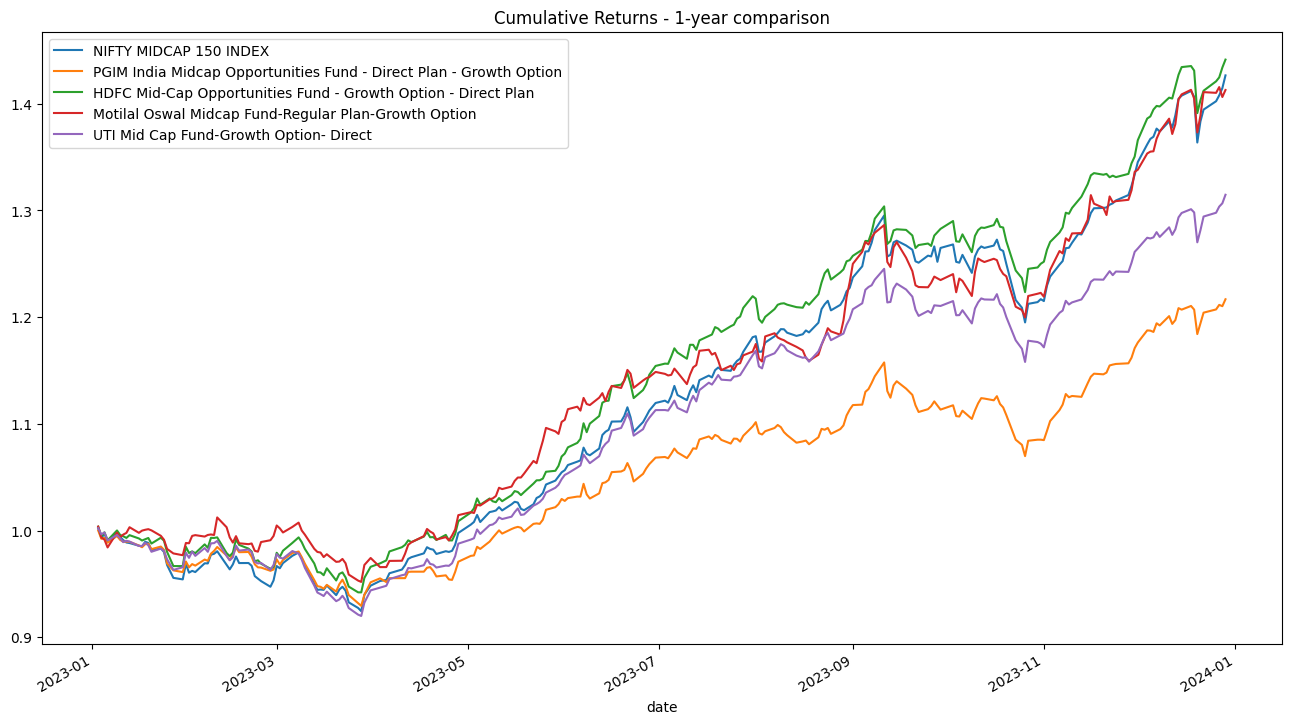

In [16]:
plt.rcParams["figure.figsize"] = [16,9]
time_period = 1

for idx, (instrument_desc, instrument_data) in enumerate(time_period_dataframes[time_period].items()):
    if idx == 0:
        ax = instrument_data.plot(y='cumulative_daily_returns', x='date', label=instrument_desc)
    else:
        instrument_data.plot(ax = ax, y='cumulative_daily_returns', x='date', label=instrument_desc)

plt.title(f"Cumulative Returns - {time_period}-year comparison")
ax.legend(loc='upper left')
plt.plot()

[]

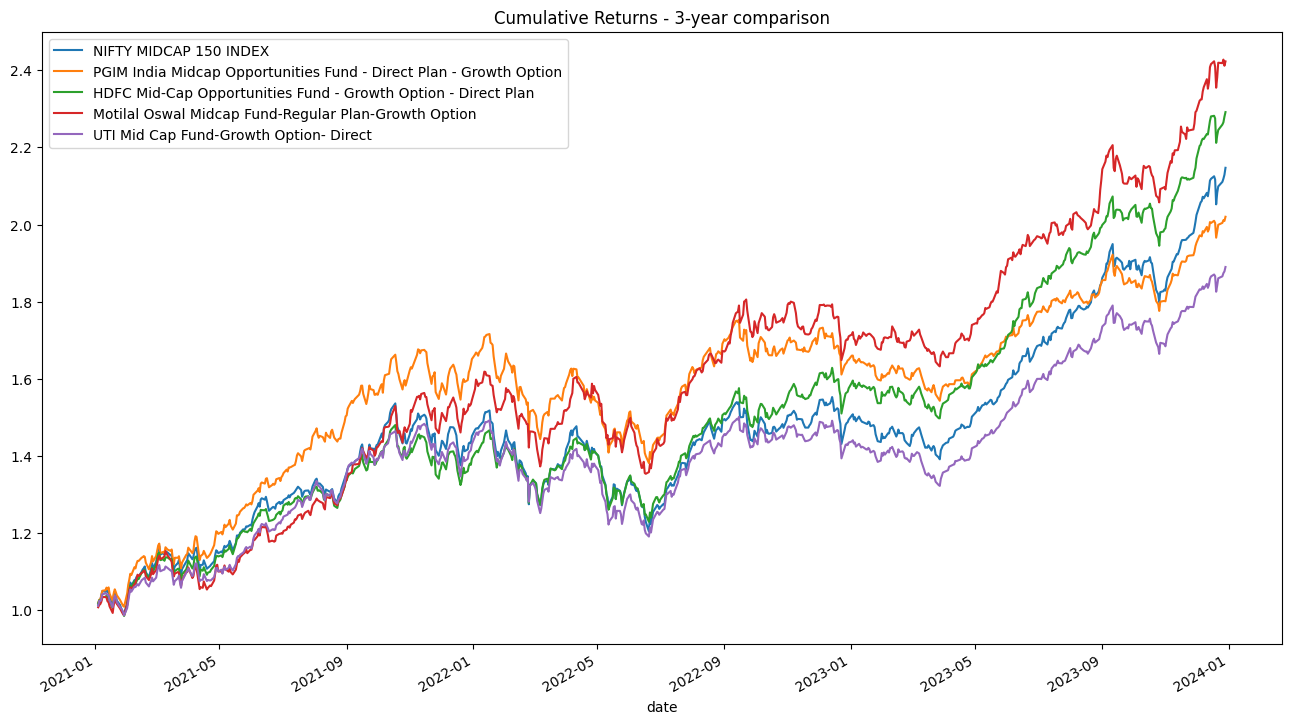

In [17]:
plt.rcParams["figure.figsize"] = [16,9]
time_period = 3

for idx, (instrument_desc, instrument_data) in enumerate(time_period_dataframes[time_period].items()):
    if idx == 0:
        ax = instrument_data.plot(y='cumulative_daily_returns', x='date', label=instrument_desc)
    else:
        instrument_data.plot(ax = ax, y='cumulative_daily_returns', x='date', label=instrument_desc)

plt.title(f"Cumulative Returns - {time_period}-year comparison")
ax.legend(loc='upper left')
plt.plot()